In [ ]:
from collections.abc import Callable
from importlib import reload

import numpy as np
from matplotlib import pyplot as plt

import L96
import relax_punch

reload(L96)
reload(relax_punch)

ndarray = np.ndarray

In [ ]:
def plot_error(
    tls: ndarray, sol: Callable, sim: Callable, I: int, J: int, J_sim: int
):
    """Plot the absolute and relative errors of the nudged solution from the
    true solution.

    Parameters
    ----------
    tls
        The t-linspace over which to plot the error
    sol
        A callable for the true solution (e.g., solve_ivp(...).sol)
    sim
        A callable for the simulated/nudged solution
    I
        The number of large-scale systems
    J
        The number of true small-scale systems
    J_sim
        The number of simulated/nudged small-scale systems
    """

    states = sol(tls)
    states_sim = sim(tls)

    error = np.linalg.norm(states - states_sim, axis=0)
    rel_error = error / np.linalg.norm(states, axis=0)

    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    ax = axs[0, 0]
    ax.plot(tls, error)
    ax.set_yscale("log")

    ax.set_xlabel("$t$")
    ax.set_title("Absolute error")
    ax.grid()

    ax = axs[0, 1]
    ax.plot(tls, rel_error)
    ax.set_yscale("log")

    ax.set_xlabel("$t$")
    ax.set_title("Relative error")
    ax.grid()

    # Extract true and nudged U and V to compare individually.
    U_trues, V_trues = zip(*[L96.apart(state, I, J) for state in states.T])
    U_trues, V_trues = np.array(U_trues).T, np.array(V_trues).T

    U_sims, V_sims = zip(
        *[L96.apart(state, I, J_sim) for state in states_sim.T]
    )
    U_sims, V_sims = np.array(U_sims).T, np.array(V_sims).T

    ax = axs[1, 0]
    U_error = np.linalg.norm((U_trues - U_sims), axis=0)
    rel_U_error = U_error / np.linalg.norm(U_trues, axis=0)

    ax.plot(tls, rel_U_error)
    ax.set_yscale("log")

    ax.set_xlabel("$t$")
    ax.set_title("Relative error in $U$")
    ax.grid()

    # TODO: Double-check that norm taken over V systems is correct (e.g., right
    # shape).
    ax = axs[1, 1]
    V_error = np.linalg.norm((V_trues - V_sims), axis=(0, 1))
    rel_V_error = V_error / np.linalg.norm(V_trues, axis=(0, 1))

    ax.plot(tls, rel_V_error)
    ax.set_yscale("log")

    ax.set_xlabel("$t$")
    ax.set_title("Relative error in $V$")
    ax.grid()

    fig.tight_layout()
    plt.show()

# Evolve without parameter updates (only nudging)

In [ ]:
# Dimensions
I, J = 40, 5
J_sim = J

# System evolution parameters
γ1, γ2 = 1e-2, 0.5
c1, c2 = γ1, γ2
ds = np.array([0.2, 0.5, 1, 2, 5])
F = 8
μ = 50

rp = relax_punch.RelaxPunch(I, J, J_sim, γ1, γ2, c1, c2, ds, F, μ)

# Initial true state
init = np.random.default_rng(42).uniform(size=I + I * J)
U0 = init[:I]
V0 = init[I:]

# Initial simulation state
U0_sim = np.zeros_like(U0)
V0_sim = np.zeros_like(V0)

T = 200

# # These options get better relative error (1e-6 instead of 1e-1 for default
# # options) but take about 20 seconds.
# options = {
#     "method": "RK45",
#     "rtol": 1e-4,
#     "max_step": 1e-2,
# }

# Relative error ~1e-5, runtime 10 seconds
options = {
    "method": "RK45",
    "rtol": 1e-5,
    "first_step": 1e-3,
}

# # Relative error ~1e-6, runtime 20 seconds
# options = {
#     "method": "RK45",
#     "rtol": 1e-6,
#     "first_step": 1e-3,
# }

# # Relative error ~1e-6, runtime 17 seconds
# options = {
#     "method": "DOP853",
#     "rtol": 1e-6,
#     "first_step": 1e-4,
# }

sol, sim = rp.evolve(0, T, U0, V0, U0_sim, V0_sim, options)

In [ ]:
tn = 2000
tls = np.linspace(0, T, tn)

states = sol.sol(tls)
Us, Vs = zip(*(L96.apart(state, I, J) for state in states.T))
Us, Vs = np.stack(Us), np.stack(Vs)

states_sim = sim.sol(tls)
Us_sim, Vs_sim = zip(*(L96.apart(state, I, J_sim) for state in states_sim.T))
Us_sim, Vs_sim = np.stack(Us_sim), np.stack(Vs_sim)

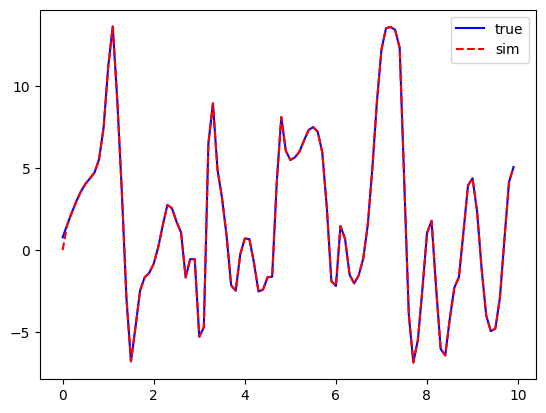

In [ ]:
s = np.s_[:100]

fig, ax = plt.subplots(1, 1)

i = 0
ax.plot(tls[s], Us.T[i, s], label="true", color="blue")
ax.plot(tls[s], Us_sim.T[i, s], label="sim", color="red", linestyle="--")

ax.legend()
plt.show()

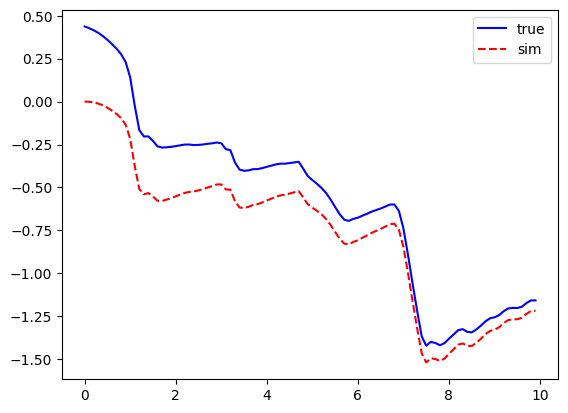

In [ ]:
fig, ax = plt.subplots(1, 1)

i = 0
ax.plot(tls[s], Vs[s, 0, i], label="true", color="blue")
ax.plot(tls[s], Vs_sim[s, 0, i], label="sim", color="red", linestyle="--")

ax.legend()
plt.show()

In [ ]:
states = sol.sol(tls)
states_sim = sim.sol(tls)

U_trues, V_trues = zip(*[L96.apart(state, I, J) for state in states.T])
U_trues, V_trues = np.array(U_trues).T, np.array(V_trues).T

U_sims, V_sims = zip(*[L96.apart(state, I, J) for state in states_sim.T])
U_sims, V_sims = np.array(U_sims).T, np.array(V_sims).T

U_error = np.linalg.norm((U_trues - U_sims), axis=0)
rel_U_error = U_error / np.linalg.norm(U_trues, axis=0)

V_error = np.linalg.norm((V_trues - V_sims), axis=(0, 1))
rel_V_error = V_error / np.linalg.norm(V_trues, axis=(0, 1))

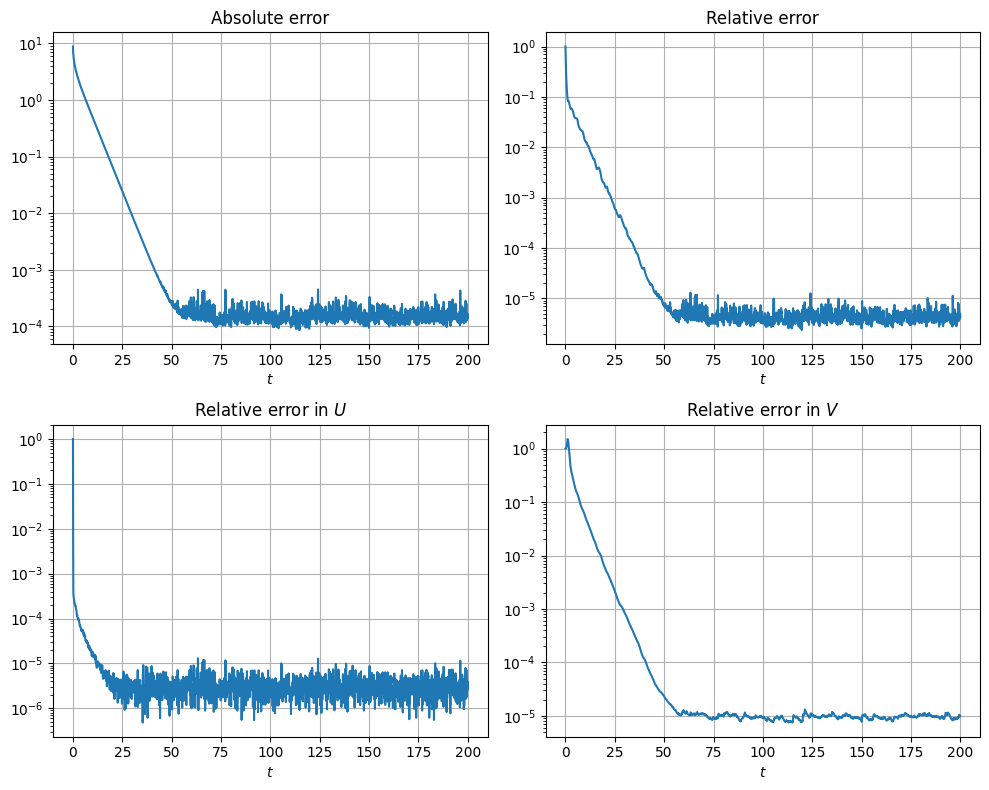

In [ ]:
plot_error(tls, sol.sol, sim.sol, I, J, J_sim)

# Evolve without parameter updates (only nudging) but multiple `solve_ivp` calls

That is, simulate for whole time using multiple calls to `solve_ivp`

In [ ]:
# Dimensions
I, J = 40, 5
J_sim = J

# System evolution parameters
γ1, γ2 = 1e-2, 0.5
c1, c2 = γ1, γ2
ds = np.array([0.2, 0.5, 1, 2, 5])
F = 8
μ = 50

Δt = 10
num_iters = 20
learning_rate = None

rp = relax_punch.RelaxPunch(I, J, J_sim, γ1, γ2, c1, c2, ds, F, μ)

# Initial true state
init = np.random.default_rng(42).uniform(size=I + I * J)
U0 = init[:I]
V0 = init[I:]

# Initial simulation state
U0_sim = np.zeros_like(U0)
V0_sim = np.zeros_like(V0)

options = {
    "method": "RK45",
    "rtol": 1e-5,
    "first_step": 1e-3,
}
rp.iterate(
    Δt,
    num_iters,
    learning_rate,
    U0,
    V0,
    U0_sim,
    V0_sim,
    options,
    param_update_method=rp._dummy_grad_desc,
)
sol, sim = rp.sol, rp.sim

In [ ]:
tn = 2000
tls = np.linspace(0, T, tn)

states = sol(tls)
Us, Vs = zip(*(L96.apart(state, I, J) for state in states.T))
Us, Vs = np.stack(Us), np.stack(Vs)

states_sim = sim(tls)
Us_sim, Vs_sim = zip(*(L96.apart(state, I, J_sim) for state in states_sim.T))
Us_sim, Vs_sim = np.stack(Us_sim), np.stack(Vs_sim)

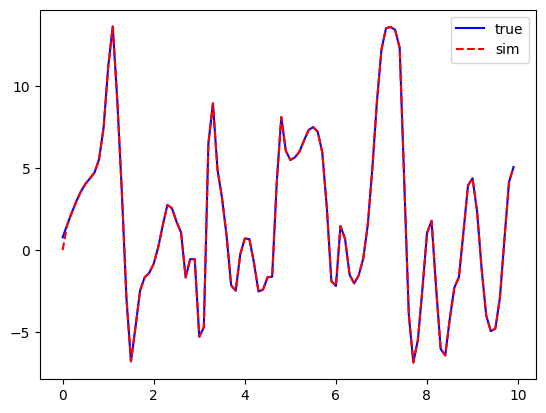

In [ ]:
s = np.s_[:100]

fig, ax = plt.subplots(1, 1)

i = 0
ax.plot(tls[s], Us.T[i, s], label="true", color="blue")
ax.plot(tls[s], Us_sim.T[i, s], label="sim", color="red", linestyle="--")

ax.legend()
plt.show()

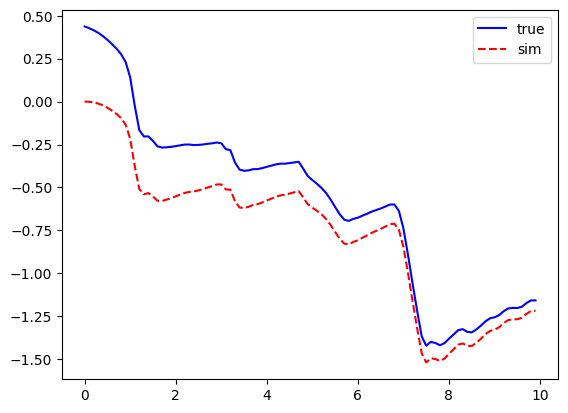

In [ ]:
fig, ax = plt.subplots(1, 1)

i = 0
ax.plot(tls[s], Vs[s, 0, i], label="true", color="blue")
ax.plot(tls[s], Vs_sim[s, 0, i], label="sim", color="red", linestyle="--")

ax.legend()
plt.show()

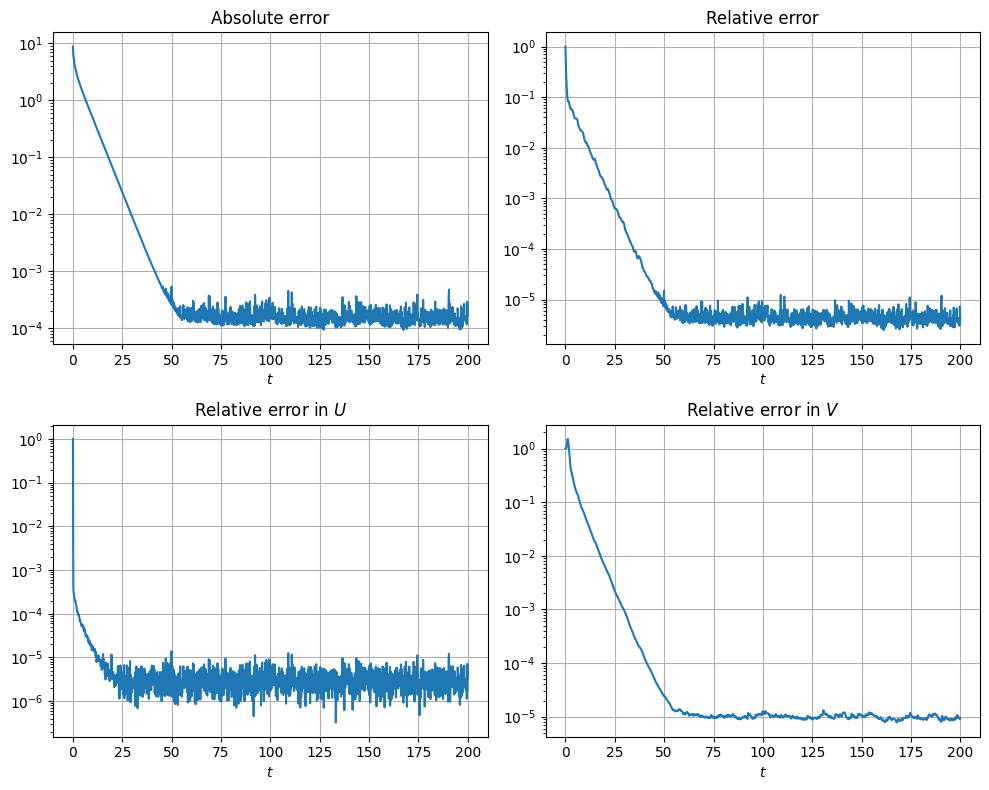

In [ ]:
plot_error(tls, sol, sim, I, J, J_sim)